# MIT License

Copyright 2020 Pablo Duboue

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

This code is derived from the Case Study in Chapter 7, see https://github.com/DrDub/artfeateng

<a href="https://colab.research.google.com/github/DrDub/riiaa20_ws25_feateng_space_time/blob/master/notebooks/2_Temporal_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import subprocess
import sys

# colab bit, adapted from https://github.com/riiaa/riiaa19_workshop_template

GIT_NAME ='riiaa20_ws25_feateng_space_time'
GIT_URL  ='https://github.com/DrDub/{}.git'.format(GIT_NAME)
IN_COLAB = 'google.colab' in sys.modules

def run_cmd(cmd):
    print('Output of "{}":'.format(cmd))
    print(subprocess.run(cmd,stdout=subprocess.PIPE, shell=True).stdout.decode('utf-8'))
        
if IN_COLAB:
    SRC_DIR='.'
    run_cmd('rm -rf sample_data')
    run_cmd('rm -rf {}'.format(GIT_NAME))
    run_cmd('git clone --verbose --progress {}'.format(GIT_URL))
    run_cmd('mv {}/* . '.format(GIT_NAME))
    run_cmd('rm -rf {}'.format(GIT_NAME))
else:
    SRC_DIR='..'
    
print('Using colab? {}, using root directory "{}"'.format(IN_COLAB,SRC_DIR))

Using colab? False, using root directory ".."


# Handling Time Series using Target Lags

This is a small datasets for country-level population prediction based on historical data.

We want to predict the population of a given country in a given year. Note that there are very few countries in the world, as such we will use few features to avoid having many more parameters than training data.

In fact, besides the population data, we will only use two other features: the number of in links and out links for the country Wikipedia page. The idea being that larger countries might have larger Wikipedia pages (resulting in more out links) and have more Wikipedia related to them (resulting in a larger number of in links).

Let us start by identifying all entities of type http://dbpedia.org/ontology/Country (Cell #18).

Countries have lots of relations coming into them, as expected. We can now merge the time series data with the relations data and split into training data and final test data (Cell #23).

In [2]:
# from CELL 23
import random
import os

rels = dict()
with open(os.path.join(SRC_DIR, "data", "ch7_cell22_rels_in_out.tsv")) as tsv:
    next(tsv) # header
    for line in tsv:
        country, rels_out, rels_in = line.strip().split("\t")
        rels[country] =  (int(rels_out), int(rels_in))

mapping = dict()
with open(os.path.join(SRC_DIR, "data", "ch7_cell21_wb_uri_mapping.tsv")) as m:
    for line in m:
        wb, db = line.strip().split("\t")
        mapping[wb] = db

data = list()
with open(os.path.join(SRC_DIR, "data", "ch7_cell19_wb_pop.tsv")) as wb:
    line = next(wb)
    header = line.strip().split("\t")
    header.insert(1, "rels_out")
    header.insert(2, "rels_in")
    for line in wb:
        fields = line.strip().split("\t")
        wb_country = fields.pop(0)
        if wb_country not in mapping:
            continue
        db_country = mapping[wb_country]
        fields = list(map(lambda x: 0 if x == '' else int(x),fields))
        fields.insert(0, rels[db_country][1])
        fields.insert(0, rels[db_country][0])
        data.append( (wb_country, fields) )
print("Data for {:,} countries".format(len(data)))
        
# save all data
with open(os.path.join(SRC_DIR, "data", "cell23_countries_data.tsv"), "w") as tsv:
    tsv.write("\t".join(header) + "\n")
    for name, fields in data:
        tsv.write(name + "\t" + "\t".join(map(str,fields)) + "\n")

# split train and final test
rand = random.Random(42)
rand.shuffle(data)
pivot = int(len(data) * 0.8)
devset = data[:pivot]
heldout = data[pivot:]
with open(os.path.join(SRC_DIR, "data", "cell23_countries_dev.tsv"), "w") as dev:
    dev.write("\t".join(header) + "\n")
    for name, fields in devset:
        dev.write(name + "\t" + "\t".join(map(str,fields)) + "\n")
with open(os.path.join(SRC_DIR, "data", "cell23_countries_held.tsv"), "w") as held:
    held.write("\t".join(header) + "\n")
    for name, fields in heldout:
        held.write(name + "\t" + "\t".join(map(str,fields)) + "\n")
print("Devset size:  {:,}".format(len(devset)))
print("Heldout size: {:,}".format(len(heldout)))

Data for 217 countries
Devset size:  173
Heldout size: 44


With the data split properly, we can start some EDA on it.

## EDA

Let's plot the relations and current population to see if there is a correlation (Cell #24).

<module 'matplotlib.pyplot' from '/home/pablo/local/virtualenv/feateng/lib/python3.6/site-packages/matplotlib/pyplot.py'>

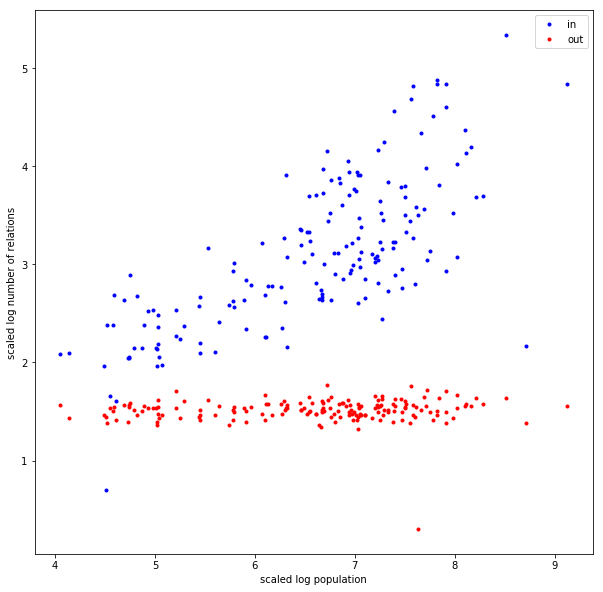

In [3]:
# from CELL 24
import math

pops = list()
num_in_rels = list()
num_out_rels = list()
with open(os.path.join(SRC_DIR, "data", "cell23_countries_dev.tsv")) as feats:
    next(feats) # skip header
    for line in feats:
        fields = line.strip().split("\t")
        pop = float(fields[-1])
        out_rels = float(fields[1])
        in_rels = float(fields[2])
        if out_rels == 0:
            continue
        pops.append(math.log(pop, 10))
        num_out_rels.append(math.log(out_rels, 10))
        num_in_rels.append(math.log(in_rels, 10))

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(pops, num_in_rels,  '.', color='blue', label='in')
plt.plot(pops, num_out_rels, '.', color='red',  label='out')
plt.xlabel('scaled log population')
plt.ylabel('scaled log number of relations')
plt.savefig(os.path.join(SRC_DIR, "media", "cell24_logpop_vs_log_items.pdf"), bbox_inches='tight', dpi=300)
plt.legend()
plt

From the figure we can see that the number of in relations is informative, but the number of out relations is not, most of the countries are involved in the same number of standard relations.

Let us now take 10 random countries and look at their time series data (Cell #25).

<module 'matplotlib.pyplot' from '/home/pablo/local/virtualenv/feateng/lib/python3.6/site-packages/matplotlib/pyplot.py'>

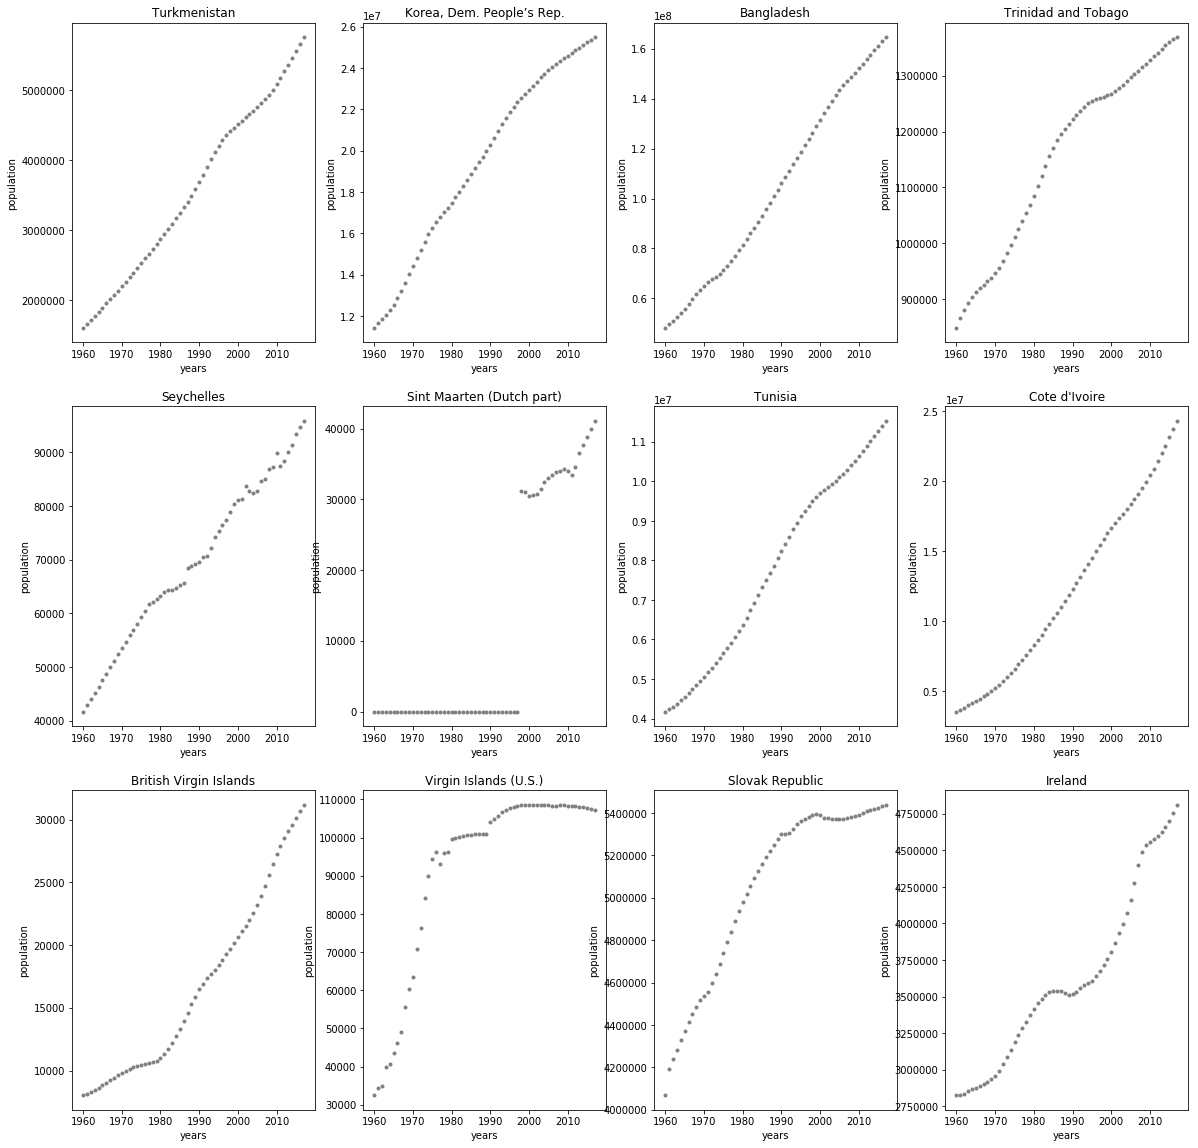

In [4]:
# from CELL 25
import math
import random

years = list()
data = list()
with open(os.path.join(SRC_DIR, "data", "cell23_countries_dev.tsv")) as feats:
    header = next(feats).strip().split("\t")
    years = list(map(int,header[3:]))
    for line in feats:
        fields = line.strip().split("\t")
        data.append( (fields[0], list(map(int,fields[3:]))) )
        
rand = random.Random(42)
rand.shuffle(data)
to_show = data[:12]

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

for idx, row in enumerate(to_show):
    plt.subplot(len(to_show) // 4, 4, idx + 1)
    
    plt.plot(years, row[1], '.', color='gray')
    plt.xlabel('years')
    plt.ylabel('population')
    plt.title(row[0])
    
plt.savefig(os.path.join(SRC_DIR, "media", "cell25_sample_country_pop.pdf"), bbox_inches='tight', dpi=300)
plt

In the figure we can see trend reversal (Ireland in the 1980-1990, Slovak Republic in 2000-2010), missing data (Sint Maarten) and a variety of curves.

## No TS data

Let us start by using only the number of relations (Cell #33) and the year.

Training on 5,997 countries / years
C 0.01 RMSE 0.7817515542948069
C 0.1 RMSE 0.7758787770834278
C 0.5 RMSE 0.7839250068144166
C 1.0 RMSE 0.7862837790964655
C 1.5 RMSE 0.7877336945407534
C 2.0 RMSE 0.7882498874305476
C 5.0 RMSE 0.7904166379445547
C 10.0 RMSE 0.7936040824048767
C 50.0 RMSE 0.7968523927665647
C 100.0 RMSE 0.8011252296159038
Best C 0.1 best RMSE 0.7758787770834278
Epsilon 0.0001 RMSE 0.7573380659894808
Epsilon 0.001 RMSE 0.7569301682550311
Epsilon 0.01 RMSE 0.7579300140735361
Epsilon 0.02 RMSE 0.7609640689373172
Epsilon 0.05 RMSE 0.7758787770834278
Epsilon 0.1 RMSE 0.769973210798563
Epsilon 0.2 RMSE 0.8025586728980024
Epsilon 0.5 RMSE 1.0280630557874224
Epsilon 0.0 RMSE 0.7576655194500849
Epsilon 1.0 RMSE 1.0280630557874224
Epsilon 10.0 RMSE 1.0280630557874224
Epsilon 100.0 RMSE 1.0280630557874224
Best epsilon 0.001 best RMSE 0.7569301682550311
RMSE 0.8497294625700124


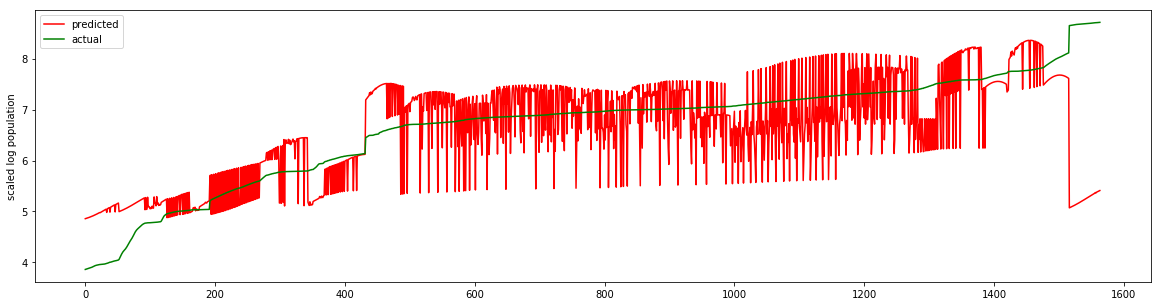

In [5]:
# from CELL 33
import math
import random
from sklearn.svm import SVR
import numpy as np

rand = random.Random(42)
train_data = list()
dev_data   = list()
test_data  = list()
header = None
with open(os.path.join(SRC_DIR, "data", "cell23_countries_dev.tsv")) as feats:
    header = next(feats)
    header = header.strip().split("\t")
    baseheader = header
    header = [ header[0], "log_" + header[1], "log_" + header[2], "year", "logpop_year" ]
    for line in feats:
        fields = line.strip().split("\t")
        name = fields[0]
        out_rels = float(fields[1])
        in_rels  = float(fields[2])
        if out_rels == 0:
            out_rels = 1
            
        isTest = rand.random() < 0.2
        isDev  = rand.random() < 0.1
        # start from +10 years to accommodate lag-10 later on
        for year_idx in range(3 + 10, len(fields)):
            pop = float(fields[year_idx])
            if not pop: # missing data? skip
                continue
            if not fields[year_idx - 10]: # missing lag data? skip
                continue

            row = ( [ math.log(out_rels, 10), math.log(in_rels, 10), int(baseheader[year_idx]) ], 
                   math.log(pop, 10), name )
            if isTest:
                test_data.append(row) 
            elif isDev:
                dev_data.append(row)
            else:
                train_data.append(row)
            
with open(os.path.join(SRC_DIR, "data", "cell33_feat1.tsv"), "w") as feat:
    feat.write("\t".join(header) + "\n")
    for feats, logpop, name in train_data + test_data:
        feat.write("{}\t{}\t{}\n".format(name, "\t".join(map(str,feats)), logpop))
               
test_data  = sorted(test_data, key=lambda t:t[1])
test_names = list(map(lambda t:t[2], test_data))

xtrain = np.array(list(map(lambda t:t[0], train_data)))
ytrain = np.array(list(map(lambda t:t[1], train_data)))
xdev   = np.array(list(map(lambda t:t[0], dev_data)))
ydev   = np.array(list(map(lambda t:t[1], dev_data)))
xtest  = np.array(list(map(lambda t:t[0], test_data)))
ytest  = np.array(list(map(lambda t:t[1], test_data)))

# SVRs need scaling
xtrain_min = xtrain.min(axis=0); xtrain_max = xtrain.max(axis=0)
# some can be zero if the column is constant in training
xtrain_diff = xtrain_max - xtrain_min
for idx in range(len(xtrain_diff)):
    if xtrain_diff[idx] == 0.0:
        xtrain_diff[idx] = 1.0
xtrain_scaling = 1.0 / xtrain_diff
xtrain -= xtrain_min; xtrain *= xtrain_scaling

ytrain_orig = ytrain.copy()
ytrain_min = ytrain.min(); ytrain_max = ytrain.max()
ytrain_scaling = 1.0 / (ytrain_max - ytrain_min)
ytrain -= ytrain_min; ytrain *= ytrain_scaling

xtest -= xtrain_min; xtest *= xtrain_scaling
ytest_orig = ytest.copy()
ytest -= ytrain_min; ytest *= ytrain_scaling

xdev -= xtrain_min; xdev *= xtrain_scaling
ydev_orig = ydev.copy()
ydev -= ytrain_min; ydev *= ytrain_scaling


# train
print("Training on {:,} countries / years".format(len(xtrain)))

# hyperparameter search
best_c = 100.0
best_epsilon = 0.05

best_rmse = 1000
for c in [0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 5.0, 10.0, 50.0, 100.0]:
    svr_rbf = SVR(epsilon=0.05, C=c, gamma='auto')
    svr_rbf.fit(xtrain, ytrain)
    ydev_pred = svr_rbf.predict(xdev)
    ydev_pred *= 1.0/ytrain_scaling
    ydev_pred += ytrain_min
    RMSE = math.sqrt(sum((ydev_orig - ydev_pred)**2) / ydev.shape[0])
    print("C", c, "RMSE", RMSE)
    if RMSE < best_rmse:
        best_c = c
        best_rmse = RMSE

print("Best C", best_c, "best RMSE", best_rmse)        

best_rmse = 1000
for epsilon in [0.0001, 0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.0, 1.0, 10.0, 100.0]:
    svr_rbf = SVR(epsilon=epsilon, C=best_c, gamma='auto')
    svr_rbf.fit(xtrain, ytrain)
    ydev_pred = svr_rbf.predict(xdev)
    ydev_pred *= 1.0/ytrain_scaling
    ydev_pred += ytrain_min
    RMSE = math.sqrt(sum((ydev_orig - ydev_pred)**2) / ydev.shape[0])
    print("Epsilon", epsilon, "RMSE", RMSE)
    if RMSE < best_rmse:
        best_epsilon = epsilon
        best_rmse    = RMSE

print("Best epsilon", best_epsilon, "best RMSE", best_rmse)

svr_rbf = SVR(epsilon=best_epsilon, C=best_c, gamma='auto')
svr_rbf.fit(xtrain, ytrain)
ytest_pred = svr_rbf.predict(xtest)
ytest_pred *= 1.0/ytrain_scaling
ytest_pred += ytrain_min
RMSE = math.sqrt(sum((ytest_orig - ytest_pred)**2) / len(ytest))
print("RMSE", RMSE)

ydev_pred = svr_rbf.predict(xdev)
ydev_pred *= 1.0/ytrain_scaling
ydev_pred += ytrain_min

dev_analysis = []
with open(os.path.join(SRC_DIR, "data", "cell33_dev_results.tsv"), "w") as f:
    f.write("\t".join(header) + "\n")
    for idx in range(len(dev_data)):
        row = dev_data[idx]
        dev_analysis.append( { 'country':  row[-1], 
                              'feats' : row[0],
                              'logpop': row[1], 
                              'pred_logpop': ydev_pred[idx] 
                             } )
        f.write("{}\t{}\t{}\t{}\n".format(row[-1], "\t".join(map(lambda x:str(x), row[0])), 
                                        row[1], ydev_pred[idx]))

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(ytest_pred, label="predicted", color='red')
plt.plot(ytest_orig, label="actual",    color='green')
plt.ylabel('scaled log population')
plt.savefig(os.path.join(SRC_DIR, "media", "cell33_svr_feat1.pdf"), bbox_inches='tight', dpi=300)
plt.legend()

The RMSE is about an order of magnitude, which is not bad for the amount of training data and pauperity of the features. 

Let's do some error analysis.

In [6]:
rand = random.Random(42)

total_diff = 0
for idx in range(len(dev_analysis)):
    row = dev_analysis[idx]
    actual    = int(10**row['logpop'])
    predicted = int(10**row['pred_logpop'])
    diff      = actual - predicted
    total_diff += diff ** 2
    if rand.random() < 0.2:
        print("{:20} {}: predicted: {:15,}   actual: {:15,}   diff: {:15,}".format(row['country'][:20],
                                                               row['feats'][-1],
                                                               predicted,
                                                               actual,
                                                               diff
                                                              ))
print("RMSE: {:,}".format(math.sqrt(total_diff / len(dev_analysis))))

Greenland            1971: predicted:         930,081   actual:          47,199   diff:        -882,882
Greenland            1977: predicted:       1,066,950   actual:          49,399   diff:      -1,017,551
Greenland            1979: predicted:       1,114,076   actual:          49,599   diff:      -1,064,477
Greenland            1982: predicted:       1,185,783   actual:          51,499   diff:      -1,134,284
Greenland            1983: predicted:       1,209,881   actual:          52,099   diff:      -1,157,782
Greenland            1989: predicted:       1,354,776   actual:          55,299   diff:      -1,299,477
Greenland            1993: predicted:       1,449,254   actual:          55,199   diff:      -1,394,055
Greenland            1996: predicted:       1,517,112   actual:          55,899   diff:      -1,461,213
Greenland            1997: predicted:       1,538,892   actual:          55,999   diff:      -1,482,893
Greenland            2011: predicted:       1,761,379   actual: 

This is missing 34 million people!

We can see how the English Wikipedia underpredicts far East countries like Thailand but overpredicts European countris like Bosnia and Hertzegovina.

Let us add the TS as extra features.

##  Using TS as Features

Because the population data is interpolated, using the year immediately before will render make the task trivial. We will thus use a minimum lag of 10, meaning we will use the known value of the population ten years before.

Training on 5,974 countries / years
C 0.01 RMSE 0.21437583225713105
C 0.1 RMSE 0.15787414722709747
C 0.5 RMSE 0.13767064369725032
C 1.0 RMSE 0.135847953857827
C 1.5 RMSE 0.13706448157875575
C 2.0 RMSE 0.1383278402748801
C 5.0 RMSE 0.14009702323204035
C 10.0 RMSE 0.13811819073675108
C 50.0 RMSE 0.1376611413800731
C 100.0 RMSE 0.13461164754838448
Best C 100.0 best RMSE 0.13461164754838448
Epsilon 0.0001 RMSE 0.03798440281866657
Epsilon 0.001 RMSE 0.037796887449411135
Epsilon 0.01 RMSE 0.03907951766398158
Epsilon 0.02 RMSE 0.05995162236052938
Epsilon 0.05 RMSE 0.13461164754838448
Epsilon 0.1 RMSE 0.2756104577302789
Epsilon 0.2 RMSE 0.5197330771431573
Epsilon 0.5 RMSE 1.0280630557874224
Epsilon 0.0 RMSE 0.03795751530191973
Epsilon 1.0 RMSE 1.0280630557874224
Epsilon 10.0 RMSE 1.0280630557874224
Epsilon 100.0 RMSE 1.0280630557874224
Best epsilon 0.001 best RMSE 0.037796887449411135
RMSE 0.05531440263594137


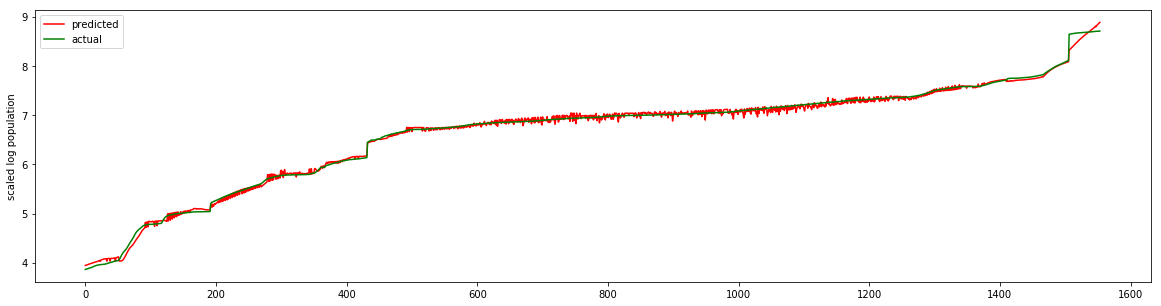

In [7]:
# from CELL 33
import math
import random
from sklearn.svm import SVR
import numpy as np

rand = random.Random(42)
train_data = list()
dev_data   = list()
test_data  = list()
header = None
with open(os.path.join(SRC_DIR, "data", "cell23_countries_dev.tsv")) as feats:
    header = next(feats)
    header = header.strip().split("\t")
    baseheader = header
    header = [ header[0], "log_" + header[1], "log_" + header[2], "year", "logpop_year_minus_10", "logpop_year" ]
    for line in feats:
        fields = line.strip().split("\t")
        name = fields[0]
        out_rels = float(fields[1])
        in_rels  = float(fields[2])
        if out_rels == 0:
            out_rels = 1
            
        isTest = rand.random() < 0.2
        isDev  = rand.random() < 0.1
        # start from +10 years to accommodate lag-10 later on
        for year_idx in range(3 + 10, len(fields)):
            pop = float(fields[year_idx])
            lagpop = float(fields[year_idx - 10])
            if not pop: # missing data? skip
                continue
            if not lagpop: # missing lag data? skip
                continue

            row = ( [ math.log(out_rels, 10), math.log(in_rels, 10), math.log(lagpop, 10), 
                     int(baseheader[year_idx]) ], 
                   math.log(pop, 10), name )
            if isTest:
                test_data.append(row) 
            elif isDev:
                dev_data.append(row)
            else:
                train_data.append(row)
            
with open(os.path.join(SRC_DIR, "data", "cell33b_feat2.tsv"), "w") as feat:
    feat.write("\t".join(header) + "\n")
    for feats, logpop, name in train_data + test_data:
        feat.write("{}\t{}\t{}\n".format(name, "\t".join(map(str,feats)), logpop))
               
test_data  = sorted(test_data, key=lambda t:t[1])
test_names = list(map(lambda t:t[2], test_data))

xtrain = np.array(list(map(lambda t:t[0], train_data)))
ytrain = np.array(list(map(lambda t:t[1], train_data)))
xdev   = np.array(list(map(lambda t:t[0], dev_data)))
ydev   = np.array(list(map(lambda t:t[1], dev_data)))
xtest  = np.array(list(map(lambda t:t[0], test_data)))
ytest  = np.array(list(map(lambda t:t[1], test_data)))

# SVRs need scaling
xtrain_min = xtrain.min(axis=0); xtrain_max = xtrain.max(axis=0)
# some can be zero if the column is constant in training
xtrain_diff = xtrain_max - xtrain_min
for idx in range(len(xtrain_diff)):
    if xtrain_diff[idx] == 0.0:
        xtrain_diff[idx] = 1.0
xtrain_scaling = 1.0 / xtrain_diff
xtrain -= xtrain_min; xtrain *= xtrain_scaling

ytrain_orig = ytrain.copy()
ytrain_min = ytrain.min(); ytrain_max = ytrain.max()
ytrain_scaling = 1.0 / (ytrain_max - ytrain_min)
ytrain -= ytrain_min; ytrain *= ytrain_scaling

xtest -= xtrain_min; xtest *= xtrain_scaling
ytest_orig = ytest.copy()
ytest -= ytrain_min; ytest *= ytrain_scaling

xdev -= xtrain_min; xdev *= xtrain_scaling
ydev_orig = ydev.copy()
ydev -= ytrain_min; ydev *= ytrain_scaling


# train
print("Training on {:,} countries / years".format(len(xtrain)))

# hyperparameter search
best_c = 100.0
best_epsilon = 0.05

best_rmse = 1000
for c in [0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 5.0, 10.0, 50.0, 100.0]:
    svr_rbf = SVR(epsilon=0.05, C=c, gamma='auto')
    svr_rbf.fit(xtrain, ytrain)
    ydev_pred = svr_rbf.predict(xdev)
    ydev_pred *= 1.0/ytrain_scaling
    ydev_pred += ytrain_min
    RMSE = math.sqrt(sum((ydev_orig - ydev_pred)**2) / ydev.shape[0])
    print("C", c, "RMSE", RMSE)
    if RMSE < best_rmse:
        best_c = c
        best_rmse = RMSE

print("Best C", best_c, "best RMSE", best_rmse)        

best_rmse = 1000
for epsilon in [0.0001, 0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.0, 1.0, 10.0, 100.0]:
    svr_rbf = SVR(epsilon=epsilon, C=best_c, gamma='auto')
    svr_rbf.fit(xtrain, ytrain)
    ydev_pred = svr_rbf.predict(xdev)
    ydev_pred *= 1.0/ytrain_scaling
    ydev_pred += ytrain_min
    RMSE = math.sqrt(sum((ydev_orig - ydev_pred)**2) / ydev.shape[0])
    print("Epsilon", epsilon, "RMSE", RMSE)
    if RMSE < best_rmse:
        best_epsilon = epsilon
        best_rmse    = RMSE

print("Best epsilon", best_epsilon, "best RMSE", best_rmse)

svr_rbf = SVR(epsilon=best_epsilon, C=best_c, gamma='auto')
svr_rbf.fit(xtrain, ytrain)
ytest_pred = svr_rbf.predict(xtest)
ytest_pred *= 1.0/ytrain_scaling
ytest_pred += ytrain_min
RMSE = math.sqrt(sum((ytest_orig - ytest_pred)**2) / len(ytest))
print("RMSE", RMSE)

ydev_pred = svr_rbf.predict(xdev)
ydev_pred *= 1.0/ytrain_scaling
ydev_pred += ytrain_min

dev_analysis2 = []
with open(os.path.join(SRC_DIR, "data", "cell33b_dev_results.tsv"), "w") as f:
    f.write("\t".join(header) + "\n")
    for idx in range(len(dev_data)):
        row = dev_data[idx]
        dev_analysis2.append( { 'country':  row[-1], 
                              'feats' : row[0],
                              'logpop': row[1], 
                              'pred_logpop': ydev_pred[idx] 
                             } )
        f.write("{}\t{}\t{}\t{}\n".format(row[-1], "\t".join(map(lambda x:str(x), row[0])), 
                                        row[1], ydev_pred[idx]))

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
plt.plot(ytest_pred, label="predicted", color='red')
plt.plot(ytest_orig, label="actual",    color='green')
plt.ylabel('scaled log population')
plt.savefig(os.path.join(SRC_DIR, "media", "cell33b_svr_feat2.pdf"), bbox_inches='tight', dpi=300)
plt.legend()

This is a good RMSE. 

Let's do some error analysis.

In [8]:
rand = random.Random(42)

total_diff = 0
for idx in range(len(dev_analysis2)):
    row = dev_analysis2[idx]
    actual    = int(10**row['logpop'])
    predicted = int(10**row['pred_logpop'])
    diff      = actual - predicted
    total_diff += diff ** 2
    if rand.random() < 0.2:
        print("{:20} {}: predicted: {:15,}   actual: {:15,}   diff: {:15,}".format(row['country'][:20],
                                                               row['feats'][-1],
                                                               predicted,
                                                               actual,
                                                               diff
                                                              ))

print("RMSE: {:,}".format(math.sqrt(total_diff / len(dev_analysis))))

Greenland            1971: predicted:          41,443   actual:          47,199   diff:           5,756
Greenland            1977: predicted:          46,982   actual:          49,399   diff:           2,417
Greenland            1979: predicted:          49,416   actual:          49,599   diff:             183
Greenland            1982: predicted:          52,115   actual:          51,499   diff:            -616
Greenland            1983: predicted:          52,614   actual:          52,099   diff:            -515
Greenland            1989: predicted:          52,375   actual:          55,299   diff:           2,924
Greenland            1993: predicted:          54,782   actual:          55,199   diff:             417
Greenland            1996: predicted:          56,177   actual:          55,899   diff:            -278
Greenland            1997: predicted:          56,790   actual:          55,999   diff:            -791
Greenland            2011: predicted:          60,081   actual: 

We are still missing almost 3 million people. It is ten times less than before, but it is still a lot of people!

Things to try for the workshop:

* Add more lags (you might want to reduce the hyperparameter search to speed things up)
* Search for the best number of lags
* Replace the lags by descriptive features regarding the history: 
  * if we are trying to predict the population a 1998 using the population values in 1978-1988, what is more relevant is whether the population increased, decreased, etc. 
  * Features can be generated from that window of numbers. 
  * In the general case, this is similar to encoding a variable length feature vector. 
  * It is possible to encode the average population at the beginning of the decade, vs. the average at the end.
* (Advanced) Use a time series library to compute the number of lags from ADF statistical test for each independent time series and use it as an extra feature. See https://github.com/DrDub/artfeateng/blob/master/Chapter7.ipynb for details.
  * Beware: I tried this before on an earlier formulation of this problem and it didn't work.